In [416]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

class1 = "dicot1"
class2 = "dicot2"
TRAIN_DIR = 'C:\\Users\\djenz\\OneDrive - University of Vermont\\Machine-Learning-Final-Project\\CNN_TRAIN_TEST\\TRAIN-'+str(class1)+'\\'
TEST_DIR = 'C:\\Users\\djenz\\OneDrive - University of Vermont\\Machine-Learning-Final-Project\\CNN_TRAIN_TEST\\TEST-'+str(class1)+"\\"
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'testing-{}-{}.model'.format(class1, class2)

In [417]:
def label_img(img):
    word_label = img.split('_')[-3]
    if word_label == class1 : return [1,0]
    elif word_label == class2 : return [0,1]

In [418]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data_'+str(class1)+'_v_'+str(class2)+'.npy', training_data)
    return training_data
        

In [419]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('_')[-3]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    np.save('test_data_'+str(class1)+'_v_'+str(class2)+'.npy', testing_data)
    return testing_data



In [420]:
train_data = create_train_data()
# if already have trained data
# train_data = np.load('train_data_'+str(class1)+'_v_'+str(class2)+'.npy')



100%|██████████| 728/728 [00:07<00:00, 102.59it/s]


In [421]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [422]:
# if os.path.exists('{}.meta'.format(MODEL_NAME)):
#     model.load(MODEL_NAME)
#     print("model loaded")



In [423]:
train = train_data[:-20]
test = train_data[-20:]



In [424]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [425]:
# Train the network
model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
# tensorboard --logdir="C:\Users\djenz\OneDrive - University of Vermont\Machine-Learning-Final-Project\CNN TUT\log"

Training Step: 599  | total loss: 0.64760 | time: 0.135s
| Adam | epoch: 050 | loss: 0.64760 - acc: 0.5983 -- iter: 704/708
Training Step: 600  | total loss: 0.65201 | time: 1.155s
| Adam | epoch: 050 | loss: 0.65201 - acc: 0.5807 | val_loss: 0.75271 - val_acc: 0.4500 -- iter: 708/708
--


In [426]:
model.save(MODEL_NAME)


INFO:tensorflow:C:\Users\djenz\OneDrive - University of Vermont\Machine-Learning-Final-Project\CNN TUT\testing-dicot1-dicot2.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 25/25 [00:00<00:00, 29.42it/s]


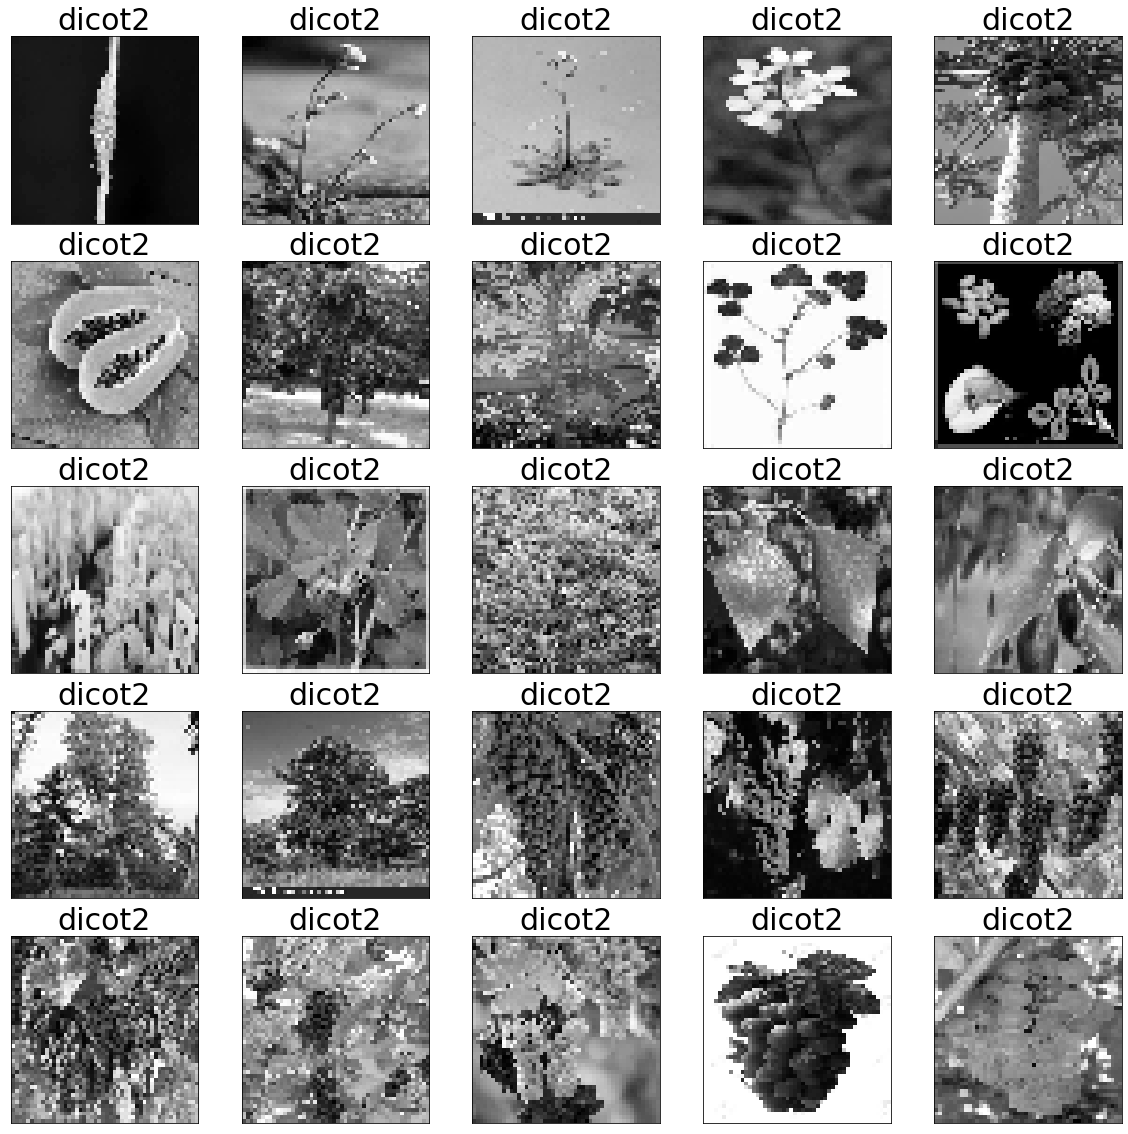

In [427]:
import matplotlib.pyplot as plt

# if you don't have this file yet
test_data = process_test_data()
#if you already have it
#test_data = np.load('test_data_'+str(class1)+'_v_'+str(class2)+'.npy', allow_pickle=True)

fig = plt.figure(figsize=(20,20))

for num, data in enumerate(test_data[:25]):
    # cat : [1,0]
    # dog : [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label=class2
    else: str_label=class1
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label, fontsize=30)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.savefig(class1+"+"+class2)
plt.show()

    

In [428]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')



In [429]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))
        
        



100%|██████████| 25/25 [00:00<00:00, 734.69it/s]
